In [1]:
import os
import sys
sys.path.insert(0,os.path.abspath('../admx_analysis_tools/datatypes_and_database/'))
sys.path.insert(0,os.path.abspath('../admx_analysis_tools/config_file_handling/main_analysis/'))
sys.path.insert(0,os.path.abspath('../admx_analysis_tools/parameter_extraction/mainline_analysis/'))
sys.path.insert(0,os.path.abspath('../admx_analysis_tools/noise_models/snr_improvement_method/'))
import admx_db_interface
import admx_db_setup
from admx_db_datatypes import PowerSpectrum
from admx_datatype_hdf5 import save_dataseries_to_hdf5,load_dataseries_from_hdf5
from config_file_handling import test_timestamp_cuts
from config_file_handling import get_intermediate_data_file_name
from snr_improvement_method import get_snr_improvement_noise_simple,load_hfet_noise,get_snr_improvement_noise_onres
from parameter_functions import searchId, smooth_parameter, convert_magnet_current_to_B_field

from uncertainties import ufloat
import numpy as np
import h5py
import time
import math
from datetime import datetime,timedelta
import yaml
import argparse
import csv
import pytz
from tqdm import tqdm
import matplotlib.pyplot as plt
import statistics
import scipy.signal as sig
from scipy.interpolate import interp1d
from pathlib import Path
import pyfftw

In [2]:
### maximum number of digitizations to pull, mostly a fail safe
max_lines=1000000
start_time="2024-05-06 17:00:00-07"
stop_time="2024-06-10 11:00:00-07"
#start_time="2024-05-24T17:00-07:00"
#stop_time="2024-05-26T17:00-07:00"

#Setup called at the beginning of every part of the analysis
setup=admx_db_setup.ADMXSetup()
db=admx_db_interface.ADMXDB()
db.hostname="10.95.101.181"

#path to save to
shift_path = "/home/ljw00010/shifts.txt

initialized


In [3]:
query1 = "SELECT timestamp,digitizer_log_reference FROM axion_scan_log WHERE timestamp < '"+str(stop_time)+"' AND timestamp>'"+str(start_time)+"' ORDER BY timestamp asc LIMIT "+str(max_lines)
records=db.send_admxdb_query(query1)
reflection_times, f0_vals = db.get_sensor_values("channel1_reflection_JPAon_f0", start_time, stop_time)
reflection_times, q_vals = db.get_sensor_values("channel1_reflection_JPAon_Q", start_time, stop_time)

In [4]:
query2 = "SELECT timestamp,power_spectrum_channel_one,digitizer_log_id,integration_time from digitizer_log WHERE timestamp < '"+str((records[len(records)-1][0] + timedelta(days=0.25)).isoformat())+"' AND timestamp > '"+str((records[0][0] - timedelta(days=0.25)).isoformat())+"' AND notes='probe_snri_baseline' ORDER BY timestamp asc LIMIT "+str(max_lines)
records2 = db.send_admxdb_query(query2)

In [172]:
def read_egg(fname,start_freq,norm_func,chop_num,chop_ind):
    '''
    This is Taj's and Leo's modified read_egg. It has a broader BW and takes in a
    generic function for normaliztion. It also segments the time series data and returns
    the data for a particular segment.
    fname: filename
    start_freq: start_freq of rf spectrum
    norm_func: function to be applied to the spectrum to produce units of sigma
    chop_num: number of segments to split the time series data into
    chop_ind: Index of segment to return data from
    '''
    
    try:
        f = h5py.File(fname,'r')
        digitizer_id = int(Path(fname).stem) #
        data = f.get("/streams/stream0/acquisitions/0")
        meta_data = f.get('streams/stream0')
        dims = np.shape(data) #Data entries are recorded as 32-bit floats, i.e. single precision.
        acq_rate = meta_data.attrs['acquisition_rate']
        numrec = dims[0] # numrec = 10000 = 'n_records'
        numbuf = int(dims[1]/2) # Number complex entries = 'record_size'
        numpts = numrec*numbuf
        reshape_data = data[:].reshape(numpts,-1)
        cdata = pyfftw.empty_aligned(numpts, dtype=np.complex64) #initilize array in memory
        cdata = reshape_data[:,0] + 1j*reshape_data[:,1] #complex time series points
        if cdata.size == 20000000: # 100s run1d files are 2e7 points long
            ts = acq_rate/(meta_data.attrs['record_size']*meta_data.attrs['n_records']*meta_data.attrs['sample_size']) #sample time
            Fs = round(1/ts) # sample rate
            # ad-hoc correction for run 1 D
            Fs *= 4
            fft_freq = np.linspace(0,Fs,numpts,endpoint=False)
            freq = fft_freq + start_freq
            chdata = np.reshape(cdata, (-1, int(cdata.size / chop_num)))
            raw_power = np.abs(pyfftw.interfaces.scipy_fftpack.fft(chdata[chop_ind]))**2 # take fft and square for power
            if not norm_func:
                retvals = (fft_freq, freq, raw_power)
            else: 
                norm_power,fit_params = norm_func(fft_freq,raw_power)
                retvals = (fft_freq, freq, norm_power)
                
            return retvals
        else:
            print(f'size {cdata.size} != 2e7')
            return [False], [False], [False]

    except (OSError,ValueError) as err:
        print(err)

In [173]:
def remove_power_excesses(freqs,spectrum,raw_spec,height,n_bins):
    """
    This function accepts a filtered spectrum and removes power excesses above a certain threshold (given by the height parameter). It is used to
    remove power excesses from the background fit, which contribute to overfitting and a reduction in our sensitivity.

    Regions which are removed due to signal excess are replaced with a linear interpolation between the two disjointed sections of the raw spectrum. 
    
    Params:
    freqs = frequencies (I added this)
    spectrum = raw spectrum with sg fit divided out (blue / orange) (dtype = PowerSpectrum)
    raw_spec = actual raw spectrum (blue)
    height = the excess level which triggers removal (dtype = float) (3.5 or 5)
    n_bins = the number of bins removed (dtype = int)
    """

    #need to loop this for removal of more than one excess within a single raw spectrum
    
    #input('Remove power excess triggered. Press enter to trigger behavior.')

    signal = raw_spec

    idx, _ = sig.find_peaks(spectrum, height=height, threshold=None) #axion location
    #idx = idx[0]
    
    #input(f'Peaks fond at {idx}. Press enter to continue.')
    bool_excess = False

    mask_excess = np.zeros(len(signal),dtype = bool) 
    for i in idx:
        idxs = np.arange(i-(n_bins//2),i+(n_bins//2),1)
        #print('before endpoint fixing')
        #print(idxs)
        # remove indices that are outside the scope of the array
        idxs[idxs < 0 ] = 0
        idxs[idxs > len(signal)-1] = len(signal)-1 #final bin in the signal??
        #print('after endpoint fixing')
        #print(idxs)
        #endpts_freqs = np.array([freqs[idxs[0]-1], freqs[idxs[-1]+1]])
        #endpts_signal = np.array([signal[idxs[0]-1], signal[idxs[-1]+1]])
        endpts_freqs = np.array([freqs[idxs[0]], freqs[idxs[-1]]])
        endpts_signal = np.array([signal[idxs[0]], signal[idxs[-1]]])
        #print(endpts_freqs)
        #print(endpts_signal)

        interpolation = interp1d(endpts_freqs, endpts_signal,fill_value='extrapolate')

        interpolated_freqs = np.arange(freqs[idxs[0]], freqs[idxs[-1]], np.median(np.diff(freqs)))
        #print(interpolated_freqs)

        #interpolated_signal = interpolation(freqs[idxs])
        interpolated_signal = interpolation(interpolated_freqs)

        #print(f'len interpolated_signal: {len(interpolated_signal)}')
        new_signal = np.append(signal[:idxs[0]],interpolated_signal)
        #print(f'len new_signal first append: {len(new_signal)}')
        new_signal = np.append(new_signal,signal[idxs[-1]:])
        #print(idxs[-1])
        #print(f'len new_signal second append: {len(new_signal)}')
        
        mask_excess[idxs[0]:idxs[-1]+1] = True

        #print(signal.size)
        signal = new_signal
        #print(signal.size)
        bool_excess = True

    spectrum = signal

    return spectrum,bool_excess,mask_excess

In [174]:
def is_trackable(digid, time, threshold=2.5):
    time_str = time.isoformat()
    date_int = int(time_str[:4] + time_str[5:7] + time_str[8:10])
    fname = "/data/high-res/" + str(date_int) + "/" + str(digid) + ".egg"
    if(os.path.isfile(fname) == False):
        date_int += 1
        fname = "/data/high-res/" + str(date_int) + "/" + str(digid) + ".egg"
    _, _, raw_spec = read_egg(fname,0,False,50,0)
    if raw_spec[0] == False:
        return False
    raw_spec = np.mean(raw_spec.reshape(-1,int(raw_spec.size/100)), axis=1)
    crns = []
    for r2 in records2:
        if time + timedelta(hours=1) < r2[0]:
            break
        if time - timedelta(hours=1) < r2[0]:
            crns.append(r2[1])
    if len(crns) <= 2:
        return False
    total_crn = np.zeros(2000)
    for crn in crns:
        total_crn = total_crn + crn
    total_crn = total_crn / len(crns)
    total_crn = np.mean(total_crn.reshape(-1,int(total_crn.size/100)), axis=1)
    corr_spec = (raw_spec / (50 * 10**10)) / total_crn
    sg_spec = sig.savgol_filter(corr_spec, 31, 4)
    xs = np.arange(0, 100, 1)
    temp = corr_spec / sg_spec
    corr_spec, _, _ = remove_power_excesses(xs, (temp - np.mean(temp)) / np.std(temp), corr_spec, 3.5, 6)
    sg_spec = sig.savgol_filter(corr_spec, 31, 4)
    test_spec = corr_spec - sg_spec
    stdevrat = np.std(sg_spec[20:80]) / np.std(test_spec)
    if stdevrat < threshold:
        return False
    else:
        return True

In [177]:
def get_shifts(digid, time, threshold = 5):
    '''
    what would need changed on another computer
    '''
    
    time_str = time.isoformat()
    date_int = int(time_str[:4] + time_str[5:7] + time_str[8:10])
    fname = "/data/high-res/" + str(date_int) + "/" + str(digid) + ".egg"
    if(os.path.isfile(fname) == False):
        date_int += 1
        fname = "/data/high-res/" + str(date_int) + "/" + str(digid) + ".egg"
    crns = []
    for r2 in records2:
        if time + timedelta(hours=1) < r2[0]:
            break
        if time - timedelta(hours=1) < r2[0]:
            crns.append(r2[1])
    total_crn = np.zeros(2000)
    for crn in crns:
        total_crn = total_crn + crn
    total_crn = total_crn / len(crns)
    total_crn = np.mean(total_crn.reshape(-1,int(total_crn.size/100)), axis=1)
    segs = np.arange(0, 50, 1)
    subspectra = []
    for s in segs:
        _, _, raw_spec = read_egg(fname,0,False,50,s)
        if raw_spec[0] == False:
            return False, [0]
        raw_spec = np.mean(raw_spec.reshape(-1,int(raw_spec.size/100)), axis=1)
        corr_spec = (raw_spec / (50 * 10**10)) / total_crn
        sg_spec = sig.savgol_filter(corr_spec, 31, 4)
        xs = np.arange(0, 100, 1)
        temp = corr_spec / sg_spec
        corr_spec, _, _ = remove_power_excesses(xs, (temp - np.mean(temp)) / np.std(temp), corr_spec, 3.5, 6)
        sg_spec = sig.savgol_filter(corr_spec, 31, 4)
        subspectra.append(sg_spec - np.mean(sg_spec))
    best_fits = []
    kernel = subspectra[0][25:75][::-1]
    for s in subspectra:
        conv = sig.convolve(kernel, s,mode='valid')
        best_fits.append(np.argmax(conv))
    f0 = best_fits[0]
    shifts = []
    shift_detected = False
    for s in best_fits:
        shifts.append((s-f0) * 2)
        if abs((s-f0) * 2) > threshold:
            shift_detected = True
    return shift_detected, shifts
    

In [36]:
idxs = np.arange(25, len(records), 50)
all_shifts = []
for idx in idxs:
    start_f0 = f0_vals[searchId(records[idx][0], reflection_times) - 1]
    end_f0 = f0_vals[searchId(records[idx][0], reflection_times)]    
    if(abs(start_f0 - end_f0) > 5000):
        if is_trackable(records[idx][1], records[idx][0]):
            has_shift, shifts = get_shifts(records[idx][1], records[idx][0], threshold=5)
            if has_shift:
                all_shifts.append((records[idx][0], records[idx][1], shifts))

/tmp/ipykernel_13102/1967519414.py:19: RuntimeWarning: invalid value encountered in divide
  total_crn = total_crn / len(crns)
/tmp/ipykernel_13102/4118348060.py:17: RuntimeWarning: invalid value encountered in divide
  total_crn = total_crn / len(crns)


In [183]:
idxs = np.arange(0, len(records), 1)
data = []
for i in idxs:
    start_f0 = f0_vals[searchId(records[i][0], reflection_times) - 1]
    end_f0 = f0_vals[searchId(records[i][0], reflection_times)]
    if(abs(start_f0 - end_f0) > 5000):
        if is_trackable(records[i][1], records[i][0]):
            has_shift, shifts = get_shifts(records[i][1], records[i][0], threshold=5)
            if has_shift:
                usable = True
                for s in shifts:
                    if abs(s) > 40:
                        usable = False
                        data.append( (records[i][1], False, "Shift greater than 40 kHz", shifts) )
                        break
                if usable:
                    data.append( (records[i][1], True, "", shifts) )
            else:
                data.append( (records[i][1], True, "", [0]) )
        else:
            data.append( (records[i][1], False, "Can't track resonance", [0]) )

size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7
size 2000000 != 2e7


In [193]:
num = 0
for d in data2:
    if d[1] == False:
        num += 1
print(num / len(records))
print(num / len(data2))
print(num)
print(len(data2))
print(len(records))

0.016646848989298454
0.05251875669882101
196
3732
11774


In [202]:
num = 0
for d in data:
    if len(d[3]) > 1:
        for s in d[3]:
            if abs(s) > 40:
                num += 1
                break
print(num)

1


In [204]:
ind = 7300
_, test_shifts = get_shifts(records[ind][1], records[ind][0])
print(test_shifts)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 4, 10, 16, 18, 20, 22, 24, 26, 32, 32, 32, 32, 34, 34, 32, 34, 36, 38, 38, 38, 38, 38, 38, 40, 40, 40]


(-100.0, 100.0)

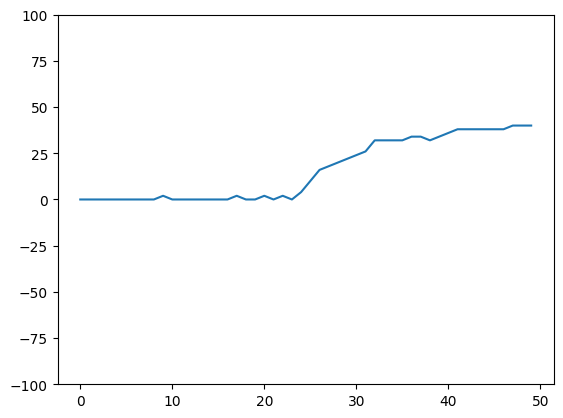

In [205]:
plt.plot(test_shifts)
ax = plt.gca()
ax.set_ylim([-100, 100])

In [203]:
digid_search = 6780224
for c in np.arange(0, len(records), 1):
    if records[c][1] == digid_search:
        print(c)

7300


In [158]:
for d in big_shift_data:
    data_backup.append(d)

In [194]:
print(data_backup)

[(6689555, True, '', [0]), (6689569, True, '', [0, 0, 0, -2, 0, 0, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -4, -4, -4, -4, -2, -4, -2, -4, -4, -4, -4, -4, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6]), (6689575, True, '', [0, 0, -2, -2, -2, 0, -2, 0, 0, 0, -2, 0, -2, 0, 0, 0, 0, -2, -2, 0, 0, 0, 0, 0, 0, 0, -2, 0, 0, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -4, -4, -4, -4, -4, -4, -6, -6, -6, -6, -6]), (6689578, True, '', [0]), (6689581, True, '', [0]), (6689627, True, '', [0]), (6689630, True, '', [0]), (6689633, True, '', [0, 0, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -4, -2, -2, -2, -2, -2, -2, -2, -4, -6]), (6689646, True, '', [0]), (6689649, True, '', [0, 0, 0, 0, -2, -2, -4, -4, -6, -6, -6, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, 